<a href="https://colab.research.google.com/github/SurajBhar/Aerial_Image_Segmentation/blob/main/Copy_of_Aerial_Image_Segmentation_with_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1 : Set up colab gpu runtime environment

In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 11.6 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=874876e6aaf6bcd32a8d79b823228d4143db025de084409ba440eb1925acb061
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=8758ba013f4dbb9876c29b41ed4a6bb0e642e1e19014cf0d28b96db1d64eb465
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels
  Cloning https://github.com/albumentations-team/albumenta

# About Dataset

### Dataset

Here the dataset which we are going to use in this guided project is the subset(200 images and its masks) of the original dataset (Massachusetts Roads Dataset) consists of 1171 aerial images of the state of Massachusetts. Each image is 1500×1500 pixels in size, covering an area of 2.25 square kilometers

### Full Dataset

After compeletion of this project you can try the same pipeline on full dataset

https://www.cs.toronto.edu/~vmnih/data/

```
@phdthesis{MnihThesis,
author = {Volodymyr Mnih},
title = {Machine Learning for Aerial Image Labeling},
school = {University of Toronto},
year = {2013}
}
```

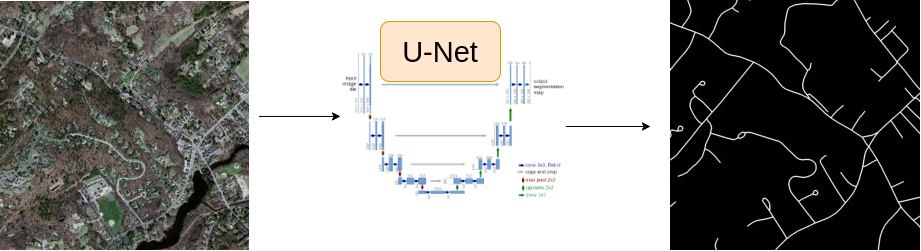

# Download Subset Dataset

In [2]:
!git clone https://github.com/parth1620/Road_seg_dataset.git

Cloning into 'Road_seg_dataset'...
remote: Enumerating objects: 411, done.
remote: Total 411 (delta 0), reused 0 (delta 0), pack-reused 411
Receiving objects: 100% (411/411), 851.74 MiB | 32.68 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Updating files: 100% (401/401), done.


# Some Common Imports

In [3]:
import sys
sys.path.append('/content/Road_seg_dataset')

In [4]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [5]:
CSV_FILE = '/content/Road_seg_dataset/train.csv'
DATA_DIR = '/content/Road_seg_dataset/'

DEVICE = 'cuda'
EPOCHS = 25
LR = 0.003
BATCH_SIZE = 8
IMG_SIZE = 512

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [6]:
df = pd.read_csv(CSV_FILE)
df.head()

,images,masks
0,images/17428750_15.png,masks/17428750_15.png
1,images/23279080_15.png,masks/23279080_15.png
2,images/24179185_15.png,masks/24179185_15.png
3,images/24179035_15.png,masks/24179035_15.png
4,images/11128810_15.png,masks/11128810_15.png


In [8]:
idx = 15
row = df.iloc[idx]
image_path  = DATA_DIR + row.images
mask_path = DATA_DIR + row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)/255

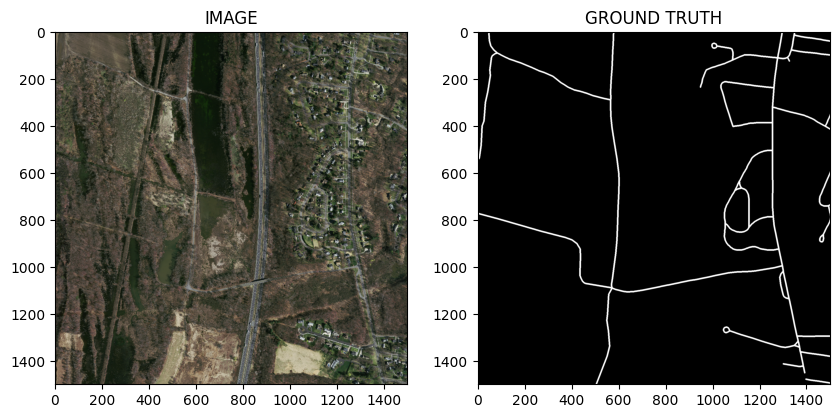

In [9]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [10]:
train_df , valid_df = train_test_split(df, test_size =0.20, random_state = 42)

In [11]:
len(train_df)

159

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [12]:
import albumentations as A

In [13]:
def get_train_augs():
  return A.Compose([A.Resize(IMG_SIZE, IMG_SIZE),
                    A.HorizontalFlip(p=0.5),
                    A.VerticalFlip(p=0.5)], is_check_shapes=False)

def get_valid_augs():
  return A.Compose([A.Resize(IMG_SIZE, IMG_SIZE)], is_check_shapes=False)

# Task 4 : Create Custom Dataset

In [14]:
from torch.utils.data import Dataset

In [16]:
class SegmentationDataset(Dataset):

  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, iidx):
    row = df.iloc[idx]
    image_path  = DATA_DIR + row.images
    mask_path = DATA_DIR + row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    mask = np.expand_dims(mask, axis = -1)

    if self.augmentations:
      data = self.augmentations(image = image, mask = mask)
      image = data['image']
      mask = data['mask']

    image = np.transpose(image, (2,0,1)).astype(np.float32)
    mask = np.transpose(mask, (2,0,1)).astype(np.float32)

    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask)) / 255.0

    return image, mask

In [17]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [18]:
print(f"The size of trainset : {len(trainset)}")
print(f"The size of validset : {len(validset)}")

The size of trainset : 159
The size of validset : 40


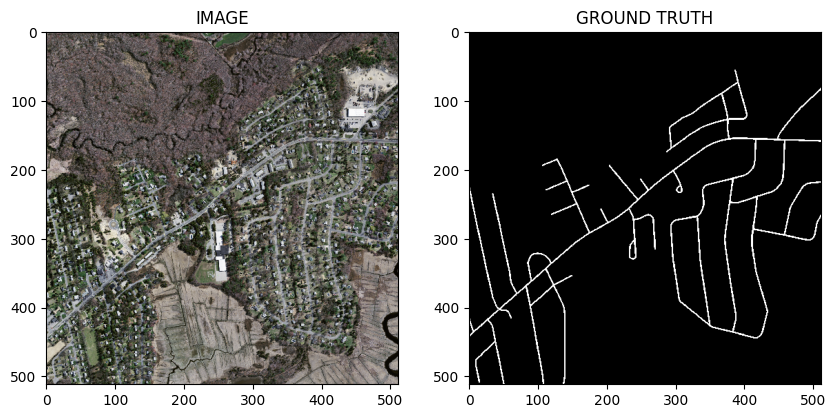

In [19]:
idx = 31
image, mask = trainset[idx]
helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [20]:
from torch.utils.data import DataLoader

In [21]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [22]:
print(f"The total number of Train batches: {len(trainloader)}")
print(f"The total number of Valid batches: {len(validloader)}")

The total number of Train batches: 20
The total number of Valid batches: 5


In [23]:
for image, mask in trainloader:
  print(image.shape)
  print(mask.shape)
  break

torch.Size([8, 3, 512, 512])
torch.Size([8, 1, 512, 512])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [24]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss


In [26]:
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel,self).__init__()

    self.backbone = smp.Unet(
        encoder_name=ENCODER,
        encoder_weights=WEIGHTS,
        in_channels= 3,
        classes = 1,
        activation = None
    ) # Output is logits.

  def forward(self, images , masks=None):
    logits = self.backbone(images)

    if masks != None:
      return logits, DiceLoss(mode = 'binary')(logits, masks) + nn.BCEWithLogitsLoss()(logits, masks)

    return logits

In [27]:
model = SegmentationModel()
model.to(DEVICE)

Downloading: "https://github.com/huggingface/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0-0af12548.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0-0af12548.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 33.9MB/s]


SegmentationModel(
  (backbone): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
      

# Task 7 : Create Train and Validation Function

In [32]:
def train_fn(data_loader, model, optimizer):
  model.train()
  total_loss = 0.0

  for images, masks in tqdm(data_loader):

    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(data_loader)

In [36]:
def eval_fn(data_loader, model):
  model.eval()
  total_loss = 0.0

  with torch.no_grad():
    for images, masks in tqdm(data_loader):

      images = images.to(DEVICE)
      masks = masks.to(DEVICE)
      logits, loss = model(images, masks)

      total_loss += loss.item()

    return total_loss / len(data_loader)

# Task 8 : Train Model

In [34]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [37]:
best_loss = np.Inf

for i in range(EPOCHS):
  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)

  if valid_loss < best_loss:
    torch.save(model.state_dict(), "best_model.pt")
    print("Saved Model")
    best_loss = valid_loss

  print(f"Epoch: {i+1} Train Loss : {train_loss} Valid Loss : {valid_loss}")

100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


Saved Model
Epoch: 1 Train Loss : 0.4903004378080368 Valid Loss : 0.6157978773117065


100%|██████████| 5/5 [00:04<00:00,  1.16it/s]


Saved Model
Epoch: 2 Train Loss : 0.21615318804979325 Valid Loss : 0.19537097215652466


100%|██████████| 5/5 [00:04<00:00,  1.11it/s]


Saved Model
Epoch: 3 Train Loss : 0.13528991304337978 Valid Loss : 0.12531329691410065


100%|██████████| 5/5 [00:08<00:00,  1.73s/it]


Saved Model
Epoch: 4 Train Loss : 0.09877478256821633 Valid Loss : 0.0934862494468689


100%|██████████| 5/5 [00:06<00:00,  1.20s/it]


Saved Model
Epoch: 5 Train Loss : 0.07630823962390423 Valid Loss : 0.07009577751159668


100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


Saved Model
Epoch: 6 Train Loss : 0.06808372046798468 Valid Loss : 0.06130080297589302


100%|██████████| 5/5 [00:04<00:00,  1.09it/s]


Epoch: 7 Train Loss : 0.05798773840069771 Valid Loss : 0.07714193314313889


100%|██████████| 5/5 [00:05<00:00,  1.16s/it]


Saved Model
Epoch: 8 Train Loss : 0.05611075479537249 Valid Loss : 0.05463580787181854


100%|██████████| 5/5 [00:04<00:00,  1.03it/s]


Saved Model
Epoch: 9 Train Loss : 0.04681275729089975 Valid Loss : 0.037862248718738556


100%|██████████| 5/5 [00:08<00:00,  1.67s/it]


Epoch: 10 Train Loss : 0.04144816156476736 Valid Loss : 0.04763456806540489


100%|██████████| 5/5 [00:05<00:00,  1.07s/it]


Saved Model
Epoch: 11 Train Loss : 0.03528469130396843 Valid Loss : 0.027575291693210602


100%|██████████| 5/5 [00:04<00:00,  1.15it/s]


Saved Model
Epoch: 12 Train Loss : 0.029124370496720075 Valid Loss : 0.020310742780566216


100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


Saved Model
Epoch: 13 Train Loss : 0.02150984713807702 Valid Loss : 0.019509853795170784


100%|██████████| 5/5 [00:04<00:00,  1.08it/s]


Saved Model
Epoch: 14 Train Loss : 0.017484808852896095 Valid Loss : 0.01403258740901947


100%|██████████| 5/5 [00:04<00:00,  1.16it/s]


Epoch: 15 Train Loss : 0.015639782790094613 Valid Loss : 0.021235406398773193


100%|██████████| 5/5 [00:04<00:00,  1.07it/s]


Saved Model
Epoch: 16 Train Loss : 0.014727574493736028 Valid Loss : 0.012703993357717991


100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


Saved Model
Epoch: 17 Train Loss : 0.01643700199201703 Valid Loss : 0.009209370240569115


100%|██████████| 5/5 [00:04<00:00,  1.16it/s]


Saved Model
Epoch: 18 Train Loss : 0.010561024956405162 Valid Loss : 0.00888206996023655


100%|██████████| 5/5 [00:04<00:00,  1.17it/s]


Saved Model
Epoch: 19 Train Loss : 0.007233871263451874 Valid Loss : 0.008698848076164722


100%|██████████| 5/5 [00:04<00:00,  1.05it/s]


Saved Model
Epoch: 20 Train Loss : 0.005512159038335085 Valid Loss : 0.0046422407031059265


100%|██████████| 5/5 [00:04<00:00,  1.00it/s]


Saved Model
Epoch: 21 Train Loss : 0.004363925696816295 Valid Loss : 0.0037036535795778036


100%|██████████| 5/5 [00:04<00:00,  1.15it/s]


Saved Model
Epoch: 22 Train Loss : 0.0034805617295205595 Valid Loss : 0.003068014746531844


100%|██████████| 5/5 [00:04<00:00,  1.15it/s]


Saved Model
Epoch: 23 Train Loss : 0.0032184598268941043 Valid Loss : 0.002985443454235792


100%|██████████| 5/5 [00:04<00:00,  1.10it/s]


Saved Model
Epoch: 24 Train Loss : 0.0026069167419336737 Valid Loss : 0.0024425722658634186


100%|██████████| 5/5 [00:04<00:00,  1.01it/s]

Saved Model
Epoch: 25 Train Loss : 0.002309656975558028 Valid Loss : 0.002144582336768508


# Task 9 : Inference

In [41]:
idx = 20

model.load_state_dict(torch.load('/content/best_model.pt'))

image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0))

pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5) * 1.0

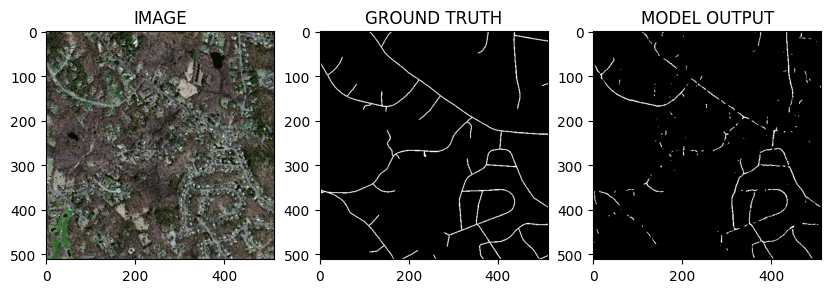

In [42]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya

